# Model details
- ***Used base model***: bert-base-uncased
- ***Used dataset***: SQuAD 2.0
- ***Batch size***: 4
- ***Early stopping patience***: 1
- ***Datasets***: Train: original 115k train samples, Val: remaining 15319 samples, Test: original 11873 samples
- ***Attempted train epochs***: 4
- ***Initial learning rate***: 3e-5
- ***Additional info***: Filtering below max tokens of the model = 512

In [1]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
)
import tensorflow as tf
from question_answering.constants import constants
from question_answering.utils import (
    core_qa_utils,
    squad2_preprocessing,
    model_management,
    predictions,
    squad_metrics,
    graphs,
    core_preprocessing,
)
from question_answering.paths import extractive_qa_paths
import ipynbname
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback
import numpy as np
from datasets import Dataset

C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Data loading

In [2]:
raw_train_dataset, raw_test_dataset = core_qa_utils.load_datasets_from_json(
    dataset_path=extractive_qa_paths.squad2_dataset_dir,
    filenames=["original_train.json", "original_test.json"],
)

In [3]:
raw_train_dataset

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
    num_rows: 130319
})

In [4]:
train_dataset = raw_train_dataset.select(range(115000))
val_dataset = raw_train_dataset.select(range(115000, 130319))
test_dataset = raw_test_dataset

In [5]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 115000
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 15319
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 11873
 }))

# Data preprocessing

In [6]:
model_checkpoint = "albert/albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Filter out samples exceeding max number of tokens

In [7]:
max_length = tokenizer.model_max_length

In [8]:
filtered_train_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=train_dataset, max_tokens=max_length
)
filtered_val_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=val_dataset, max_tokens=max_length
)
filtered_test_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=test_dataset, max_tokens=max_length
)

Filter:   0%|          | 0/15319 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


In [9]:
print(f"Train | BEFORE: {len(train_dataset)} | AFTER: {len(filtered_train_dataset)}")
print(f"Val | BEFORE: {len(val_dataset)} | AFTER: {len(filtered_val_dataset)}")
print(f"Test | BEFORE: {len(test_dataset)} | AFTER: {len(filtered_test_dataset)}")

Train | BEFORE: 115000 | AFTER: 114812
Val | BEFORE: 15319 | AFTER: 15291
Test | BEFORE: 11873 | AFTER: 11778


In [10]:
tokenized_train_dataset = (
    squad2_preprocessing.preprocess_squad2_training_dataset_no_stride(
        dataset=filtered_train_dataset,
        tokenizer=tokenizer,
        max_length=max_length,
        remove_columns=train_dataset.column_names,
    )
)
tokenized_val_dataset = squad2_preprocessing.preprocess_squad2_training_dataset_no_stride(
    dataset=filtered_val_dataset,
    tokenizer=tokenizer,
    max_length=max_length,
    remove_columns=val_dataset.column_names,
)

Map:   0%|          | 0/15291 [00:00<?, ? examples/s]

In [11]:
tokenized_test_dataset = squad2_preprocessing.preprocess_squad2_test_dataset_no_stride(
    dataset=filtered_test_dataset,
    tokenizer=tokenizer,
    max_length=max_length,
    remove_columns=test_dataset.column_names,
)

# Training preparation

In [12]:
# Model parameters
full_model_name = "-".join(ipynbname.name().split("_"))

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
        extractive_qa_paths.training_checkpoints_dir
        / full_model_name
        / checkpoint_filename_template
)

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = extractive_qa_paths.model_evaluation_dir / full_model_name
figures_dir = model_evaluation_dir / constants.figures_dir_name

# Hyper parameters
batch_size = 4
train_epochs = 4
initial_learning_rate = 3e-5
end_learning_rate = 0

In [13]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_val_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_val_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=None,
    collator=data_collator,
    batch_size=batch_size,
)

In [14]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFAlbertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFAlbertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, save_weights_only=True
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=1)
time_measure_cb = TimeMeasureCallback()

callbacks = [checkpoint_cb, early_stop_cb, time_measure_cb]

In [16]:
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=num_train_steps,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
qa_metrics = ["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=qa_metrics)

In [17]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


# Model training

In [18]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/4
28703/28703 [==============================] - 5158s 179ms/step - loss: 2.4462 - end_logits_loss: 1.1778 - start_logits_loss: 1.2684 - end_logits_accuracy: 0.6464 - start_logits_accuracy: 0.6243 - val_loss: 2.0623 - val_end_logits_loss: 0.9936 - val_start_logits_loss: 1.0687 - val_end_logits_accuracy: 0.7017 - val_start_logits_accuracy: 0.6760
Epoch 2/4
28703/28703 [==============================] - 5147s 179ms/step - loss: 1.5686 - end_logits_loss: 0.7490 - start_logits_loss: 0.8196 - end_logits_accuracy: 0.7662 - start_logits_accuracy: 0.7417 - val_loss: 1.8233 - val_end_logits_loss: 0.8697 - val_start_logits_loss: 0.9536 - val_end_logits_accuracy: 0.7361 - val_start_logits_accuracy: 0.7088
Epoch 3/4
28703/28703 [==============================] - 5080s 177ms/step - loss: 1.0496 - end_logits_loss: 0.4952 - start_logits_loss: 0.5545 - end_logits_accuracy: 0.8411 - start_logits_accuracy: 0.8176 - val_loss: 1.9125 - val_end_logits_loss: 0.9077 - val_start_logits_loss: 1.0049 - 

In [19]:
history = history.history

In [20]:
core_qa_utils.save_dict_as_json(
    dictionary=history, dir_path=model_evaluation_dir, filename="history.json"
)

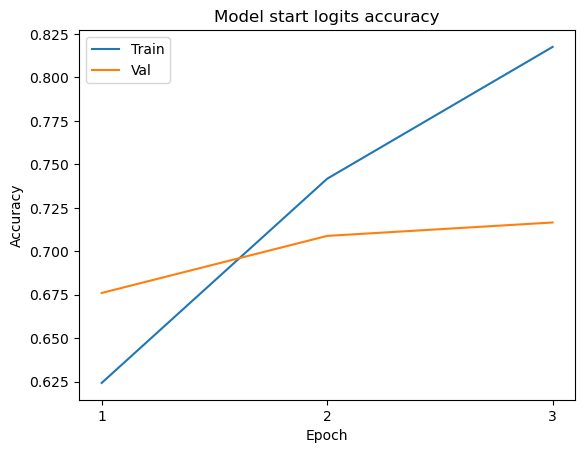

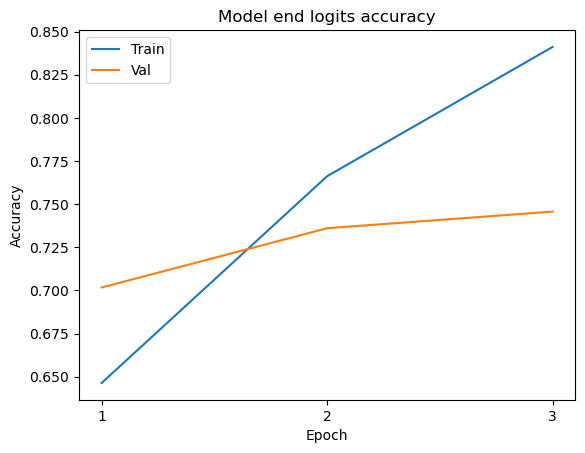

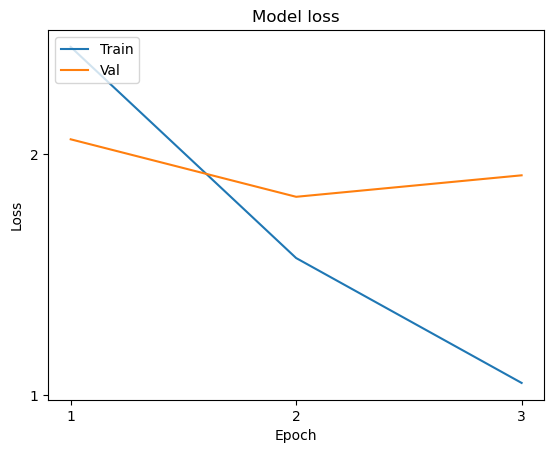

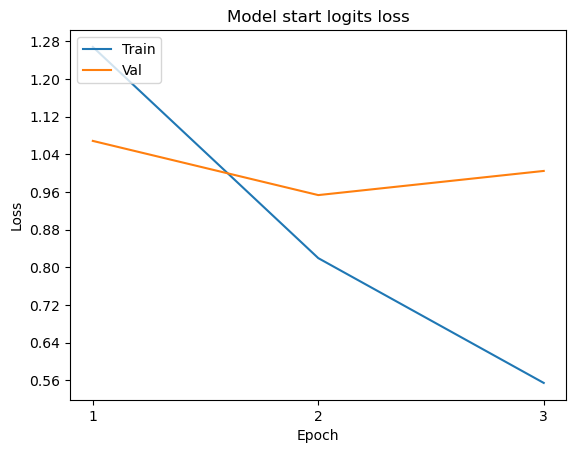

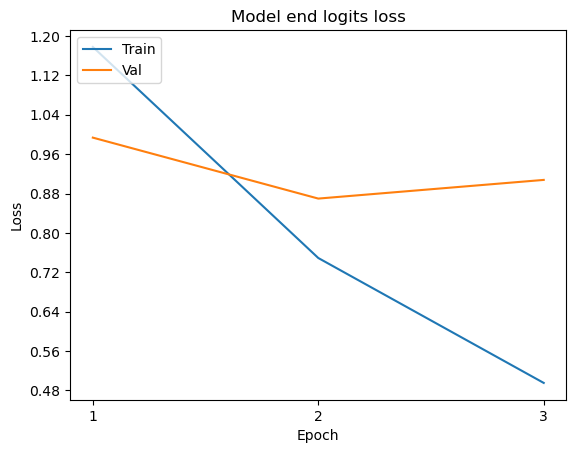

In [21]:
# Plot training figures
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_accuracy", "val_start_logits_accuracy"],
    title="Model start logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"start_accuracy.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_accuracy", "val_end_logits_accuracy"],
    title="Model end logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"end_accuracy.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["loss", "val_loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"loss.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_loss", "val_start_logits_loss"],
    title="Model start logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"start_loss.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_loss", "val_end_logits_loss"],
    title="Model end logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"end_loss.png",
)

# Saving model's best version & training data

In [22]:
history = core_qa_utils.read_json_as_dict(model_evaluation_dir / "history.json")

In [23]:
best_epoch = core_qa_utils.get_best_epoch(
    history=history, metric="val_loss", metric_evaluator="min"
)

In [24]:
training_data = {
    "history": history,
    "attempted_epochs": train_epochs,
    "best_epoch": best_epoch,
    "training_time": time_measure_cb.total_training_time(),
    "gpu": core_qa_utils.get_gpu_name(),
}

In [25]:
core_qa_utils.save_dict_as_json(
    training_data, dir_path=model_evaluation_dir, filename="training_data.json"
)

In [26]:
best_model = model_management.load_best_model_from_checkpoints(
    model=model, model_name=full_model_name, epoch=best_epoch, remove_checkpoints=True
)

In [27]:
model_management.save_model(model=best_model, model_name=full_model_name)

# Getting predictions

In [28]:
loaded_model = model_management.load_model(
    model_checkpoint=model_checkpoint, model_name=full_model_name
)

All PyTorch model weights were used when initializing TFAlbertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFAlbertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
output = loaded_model.predict(tf_test_dataset)

2945/2945 [==============================] - 161s 54ms/step


In [30]:
# Get predictions
output_start_logits = predictions.get_preds(
    output, output_key="start_logits", return_type="logits"
)
output_end_logits = predictions.get_preds(
    output, output_key="end_logits", return_type="logits"
)

output_start_positions = predictions.get_preds(
    output, output_key="start_logits", return_type="class"
)
output_end_positions = predictions.get_preds(
    output, output_key="end_logits", return_type="class"
)

In [31]:
def get_predicted_texts_for_multiple_n_best(
        start_logits: np.ndarray,
        end_logits: np.ndarray,
        features: Dataset,
        examples: Dataset,
        n_best_variants: list[int],
):
    predicted_texts_for_varying_n_best = []
    for n_best_variant in n_best_variants:
        predicted_texts = predictions.get_predicted_texts(
            start_logits=start_logits,
            end_logits=end_logits,
            features=features,
            examples=examples,
            n_best=n_best_variant,
        )
        predicted_texts_for_varying_n_best.append(predicted_texts)

    return predicted_texts_for_varying_n_best

In [32]:
n_bests = ["01", "02", "03", "05"]

textual_predictions_variants = get_predicted_texts_for_multiple_n_best(
    start_logits=output_start_logits,
    end_logits=output_end_logits,
    features=tokenized_test_dataset,
    examples=test_dataset,
    n_best_variants=[int(n_best) for n_best in n_bests],
)

# Metrics & evaluation

### Stats

In [33]:
metric_stats = squad_metrics.calculate_squad_metrics_stats(
    start_actual=tokenized_test_dataset["start_positions"],
    end_actual=tokenized_test_dataset["end_positions"],
    start_preds=output_start_positions,
    end_preds=output_end_positions,
)
metric_stats

{'count_of_no_answer_predictions': 5513,
 'count_of_start_after_end_predictions': 211,
 'count_of_good_no_answer_predictions': 4673,
 'count_of_bad_no_answer_predictions': 840,
 'count_of_bad_predictions': 3239,
 'count_of_good_predictions': 8539,
 'total_predictions': 11778}

### Accuracies

In [34]:
accuracies_metrics = squad_metrics.calculate_squad_accuracies(
    start_actual=tokenized_test_dataset["start_positions"],
    end_actual=tokenized_test_dataset["end_positions"],
    start_preds=output_start_positions,
    end_preds=output_end_positions,
)
accuracies_metrics

{'start_accuracy': 0.7627780607913058,
 'end_accuracy': 0.7712684666327051,
 'full_accuracy': 0.717099677364578}

### Precision, recall, F1-score, exact match

In [35]:
def calculate_all_variants_of_squad_qa_metrics(
        answers: list[list[str]],
        predicted_texts_variants: list[list[str]],
):
    metrics = []
    for predicted_texts_variant in predicted_texts_variants:
        non_normalized_metrics = squad_metrics.calculate_squad_qa_metrics(
            answers=answers, predicted_texts=predicted_texts_variant, normalize=False
        )
        normalized_metrics = squad_metrics.calculate_squad_qa_metrics(
            answers=answers, predicted_texts=predicted_texts_variant, normalize=True
        )
        metrics.append(non_normalized_metrics)
        metrics.append(normalized_metrics)

    return metrics

In [36]:
qa_metrics = calculate_all_variants_of_squad_qa_metrics(
    answers=test_dataset["answer_text"],
    predicted_texts_variants=textual_predictions_variants,
)

### Correct predictions by sentence lengths

In [37]:
non_normalized_qa_metrics = qa_metrics[::2]
non_normalized_f1_scores = [qa_metric["f1"] for qa_metric in non_normalized_qa_metrics]
best_n_best = non_normalized_f1_scores.index(max(non_normalized_f1_scores))

In [38]:
best_textual_predictions = textual_predictions_variants[best_n_best]
correctly_predicted = squad_metrics.get_is_correctly_predicted(
    answers=test_dataset["answer_text"],
    predicted_texts=best_textual_predictions,
    normalize=True,
)

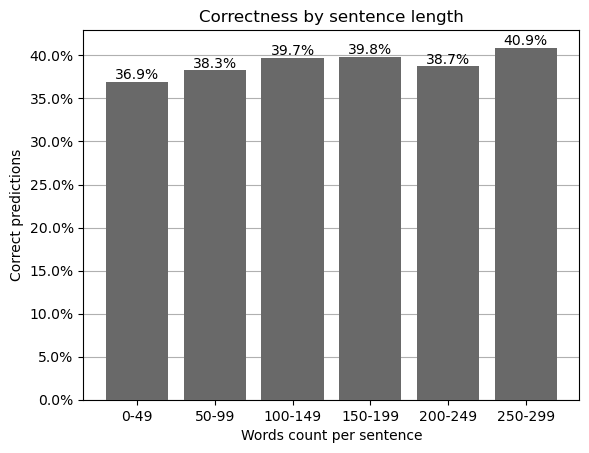

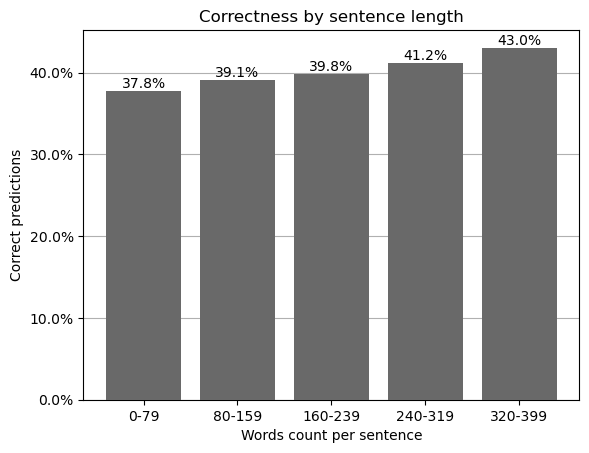

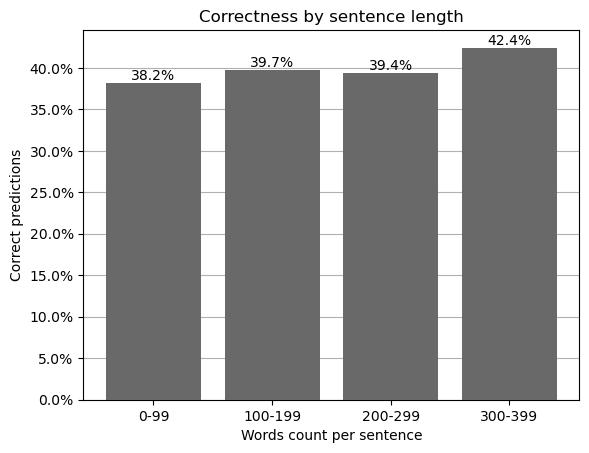

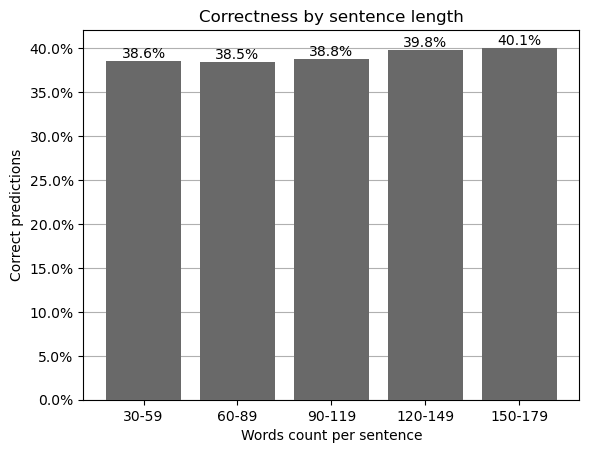

In [39]:
# Plot correctness of the model by sentence length
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_0_300_50.png",
    figure_title="Correctness by sentence length",
    divider=50,
    min_threshold=0,
    max_threshold=300,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_0_400_80.png",
    figure_title="Correctness by sentence length",
    divider=80,
    min_threshold=0,
    max_threshold=400,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_0_400_100.png",
    figure_title="Correctness by sentence length",
    divider=100,
    min_threshold=0,
    max_threshold=400,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_30_180_30.png",
    figure_title="Correctness by sentence length",
    divider=30,
    min_threshold=30,
    max_threshold=180,
)

### Saving evaluation data

In [40]:
def get_all_variants_of_qa_metric(all_metrics, metric_name: str):
    return {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": all_metrics[
            i
        ][metric_name]
        for i in range(len(n_bests) * 2)
    }

In [41]:
evaluation_data = {
    "accuracy": accuracies_metrics,
    "metric_stats": metric_stats,
    "precision": get_all_variants_of_qa_metric(qa_metrics, "precision"),
    "recall": get_all_variants_of_qa_metric(qa_metrics, "recall"),
    "f1": get_all_variants_of_qa_metric(qa_metrics, "f1"),
    "exact_match": get_all_variants_of_qa_metric(qa_metrics, "exact_match"),
}

In [42]:
core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)